<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego colab a google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importo le librerie necessarie

In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 70.8 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show
import torch.nn as nn
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import torchvision
from osgeo import gdal
import cv2
import tifffile as tiff
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import copy

Definisco alcune directory

In [4]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

Media e std calcolate in Funzioni.ipynb

In [5]:
# mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
# std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
mean = [0.0, 0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0, 1.0]

Definisco le traformazioni

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Definiamo la classe SARDataset

In [6]:
# class SARDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, transform=None):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]

#         image = tiff.imread(image_path)
#         image = image.astype(np.float32)
#         image[image == 255.0] = 1.0
#         mask = tiff.imread(mask_path)
#         if mask.ndim == 3:
#             mask = mask[:, :, 0]


#         mask = mask.astype(np.float32)
#         mask[mask == 255.0] = 1.0



#         if image.shape[:2] != mask.shape:
#             raise ValueError(f"Le dimensioni dell'immagine {image_path} e della maschera {mask_path} non corrispondono.")


#         if self.transform is not None:
#             augmentations = self.transform(image=image, mask=mask)
#             image = augmentations["image"]
#             mask = augmentations["mask"]



#         return image, mask
class SARDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        print(f"Loading image: {image_path}")


        image = tiff.imread(image_path)

        mask = tiff.imread(mask_path)
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        mask = mask.astype(np.float32)
        mask[mask == 255.0] = 1.0


        if image.shape[:2] != mask.shape:
            raise ValueError(f"Le dimensioni dell'immagine {image_path} e della maschera {mask_path} non corrispondono.")

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

Carico i percorsi delle immagini per il training, il validation e il test set

In [7]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]
train_label_paths = [line[1] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]
val_label_paths = [line[1] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]
test_label_paths = [line[1] for line in test_data]

Creo il modello UNET

Classe DoubleConv

In [8]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)



Classe UNET

In [9]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=4, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

Test

In [10]:
def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == "__main__":
  test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


Seed

In [10]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

Funzione per il training

In [11]:
# def train_fn(loader, model, optimizer, loss_fn, scaler):
#     loop = tqdm(loader)

#     for batch_idx, (data, targets) in enumerate(loop):
#         data = data.to(device=device)
#         targets = targets.float().unsqueeze(1).to(device=device)

#         with torch.cuda.amp.autocast():
#             predictions = model(data)
#             loss = loss_fn(predictions, targets)


#         optimizer.zero_grad()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         loop.set_postfix(loss=loss.item())

#         torch.cuda.empty_cache()
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, device='cuda'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    train_losses = []
    val_losses = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_accuracies = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            all_preds = []
            all_labels = []

            for inputs, labels in tqdm(data_loader, desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', leave=False):
                inputs = inputs.to(device)
                labels = labels.unsqueeze(1).to(device)

                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())

                del inputs, labels, outputs
                torch.cuda.empty_cache()

            epoch_loss = running_loss / len(data_loader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                scheduler.step()
            else:
                val_losses.append(epoch_loss)
                precision = precision_score(all_labels, all_preds)
                recall = recall_score(all_labels, all_preds)
                f1 = f1_score(all_labels, all_preds)
                accuracy = accuracy_score(all_labels, all_preds)

                val_precisions.append(precision)
                val_recalls.append(recall)
                val_f1s.append(f1)
                val_accuracies.append(accuracy)

                if f1 > best_f1:
                    best_f1 = f1
                    best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

Utils

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

Loaders

In [ ]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
    train_dataset = SARDataset(train_image_paths, train_label_paths, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
    val_dataset = SARDataset(val_image_paths, val_label_paths, transform=train_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

Accuracy

In [ ]:
def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

  print(
      f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
  )
  print(f"Dice score: {dice_score/len(loader)}")

  model.train()

In [ ]:
def save_predictions_as_imgs(loader, model, folder, device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(tqdm(loader, desc="Saving predictions")):
        x = x.to(device=device)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        for i in range(preds.shape[0]):
            pred_tiff_path = os.path.join(folder, f"pred_{idx * loader.batch_size + i}.png")
            tiff.imwrite(pred_tiff_path, preds[i].cpu().numpy().astype('float32'))


        for i in range(y.shape[0]):
            label_tiff_path = os.path.join(folder, f"label_{idx * loader.batch_size + i}.png")
            tiff.imwrite(label_tiff_path, y[i].cpu().numpy().astype('float32'))

    model.train()


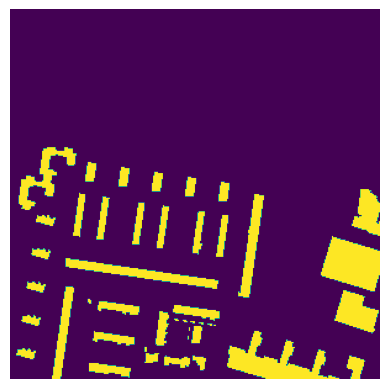

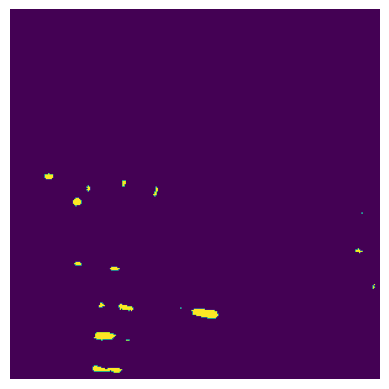

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np


def visualize_tiff(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        plt.axis('off')
        plt.show()


image_path = drive_dir + '/saved_images/label_310.png'


visualize_tiff(image_path)

image_path = drive_dir + '/saved_images/pred_310.png'

visualize_tiff(image_path)


In [12]:
set_seed(42)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

train_dataset = SARDataset(train_image_paths, train_label_paths, transform=transform)
val_dataset = SARDataset(val_image_paths, val_label_paths, transform=transform,)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=27, gamma=0.1)


In [13]:
best_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, device=device)

Train Epoch 1/30:   0%|          | 0/298 [00:00<?, ?it/s]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823075318_20190823075613_tile_5269.tifLoading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823161251_20190823161546_tile_8301.tif

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823071743_20190823072036_tile_2627.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823091635_20190823091951_tile_8797.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823142111_20190823142355_tile

Train Epoch 1/30:   0%|          | 1/298 [00:38<3:11:41, 38.72s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822160239_20190822160529_tile_3884.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823152527_20190823152847_tile_5822.tif


Train Epoch 1/30:   1%|          | 2/298 [00:41<1:25:21, 17.30s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823090045_20190823090358_tile_988.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823092528_20190823092835_tile_1210.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822141103_20190822141406_tile_4966.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822085638_20190822085935_tile_10658.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823072627_20190823072925_tile

Train Epoch 1/30:   1%|          | 3/298 [00:51<1:09:17, 14.09s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823082145_20190823082444_tile_7810.tif


Train Epoch 1/30:   1%|▏         | 4/298 [00:53<46:35,  9.51s/it]  

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804141608_20190804141830_tile_5336.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823070415_20190823070716_tile_6356.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823143102_20190823143400_tile_5997.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823130736_20190823131054_tile_4267.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822153558_20190822153835_tile

Train Epoch 1/30:   2%|▏         | 5/298 [01:46<2:02:58, 25.18s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822083256_20190822083600_tile_10922.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822073746_20190822074042_tile_5392.tif


Train Epoch 1/30:   2%|▏         | 6/298 [01:49<1:24:58, 17.46s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823065021_20190823065333_tile_9154.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823101134_20190823101448_tile_2845.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822082538_20190822082826_tile_4152.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823142603_20190823142913_tile_3554.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822083256_20190822083600_tile

Train Epoch 1/30:   2%|▏         | 7/298 [02:04<1:20:43, 16.64s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822141103_20190822141406_tile_4975.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822145832_20190822150114_tile_9609.tif


Train Epoch 1/30:   3%|▎         | 8/298 [02:06<58:35, 12.12s/it]  

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822144046_20190822144338_tile_1480.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822150221_20190822150509_tile_8526.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822143613_20190822143904_tile_4916.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823144405_20190823144711_tile_3340.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823142603_20190823142913_tile

Train Epoch 1/30:   3%|▎         | 9/298 [02:27<1:10:52, 14.71s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822100114_20190822100413_tile_675.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804135937_20190804140208_tile_6570.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804121908_20190804122131_tile_6677.tif


Train Epoch 1/30:   3%|▎         | 10/298 [02:29<52:26, 10.92s/it] 

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804123547_20190804123823_tile_6155.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822073257_20190822073557_tile_2426.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823153025_20190823153316_tile_5087.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822133830_20190822134118_tile_3787.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822134835_20190822135131_tile

Train Epoch 1/30:   4%|▎         | 11/298 [02:45<1:00:06, 12.57s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822145028_20190822145325_tile_9219.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161045_20190822161339_tile_2484.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8685.tif


Train Epoch 1/30:   4%|▍         | 12/298 [02:48<45:00,  9.44s/it]  

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823132244_20190823132535_tile_2789.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822071501_20190822071737_tile_6721.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822073746_20190822074042_tile_5388.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823125732_20190823130048_tile_1922.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822072817_20190822073109_tile

Train Epoch 1/30:   4%|▍         | 13/298 [03:04<55:37, 11.71s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804124749_20190804125033_tile_3672.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823100628_20190823100943_tile_5446.tif


Train Epoch 1/30:   5%|▍         | 14/298 [03:07<41:58,  8.87s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823093023_20190823093332_tile_8951.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822080151_20190822080440_tile_612.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804133705_20190804133940_tile_5556.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823074455_20190823074758_tile_10203.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823084056_20190823084400_tile

Train Epoch 1/30:   5%|▌         | 15/298 [03:20<48:01, 10.18s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822144546_20190822144829_tile_7596.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822143613_20190822143904_tile_4918.tif


Train Epoch 1/30:   5%|▌         | 16/298 [03:22<36:43,  7.81s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6250.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823080230_20190823080526_tile_1976.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823144405_20190823144711_tile_3347.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823132244_20190823132535_tile_2786.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823065505_20190823065800_tile

Train Epoch 1/30:   6%|▌         | 17/298 [03:37<46:39,  9.96s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823075755_20190823080053_tile_10758.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114132_20190804114404_tile_10819.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822133830_20190822134118_tile_3771.tif


Train Epoch 1/30:   6%|▌         | 18/298 [03:40<35:45,  7.66s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822070610_20190822070846_tile_3735.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822153558_20190822153835_tile_2538.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822143107_20190822143418_tile_1550.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823085011_20190823085317_tile_6947.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823082625_20190823082938_tile

Train Epoch 1/30:   6%|▋         | 19/298 [03:55<46:03,  9.90s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804133705_20190804133940_tile_5548.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823143102_20190823143400_tile_5991.tif


Train Epoch 1/30:   7%|▋         | 20/298 [03:57<35:17,  7.62s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822144546_20190822144829_tile_7592.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823133754_20190823134101_tile_282.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822152811_20190822153054_tile_13.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804115211_20190804115445_tile_8029.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823093023_20190823093332_tile_89

Train Epoch 1/30:   7%|▋         | 21/298 [04:14<47:41, 10.33s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804140510_20190804140727_tile_4700.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823094036_20190823094408_tile_10259.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823080230_20190823080526_tile_1974.tif


Train Epoch 1/30:   7%|▋         | 22/298 [04:16<36:23,  7.91s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823144849_20190823145144_tile_3275.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823153502_20190823153756_tile_3826.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823070415_20190823070716_tile_6359.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804135332_20190804135556_tile_7174.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823085011_20190823085317_tile

Train Epoch 1/30:   8%|▊         | 23/298 [04:32<47:20, 10.33s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823070415_20190823070716_tile_6357.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804121908_20190804122131_tile_6670.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823145306_20190823145612_tile_7216.tif


Train Epoch 1/30:   8%|▊         | 24/298 [04:34<36:08,  7.91s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823131744_20190823132104_tile_3506.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823151153_20190823151440_tile_6052.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823144405_20190823144711_tile_3344.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161837_20190822162134_tile_1592.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822143613_20190822143904_tile

Train Epoch 1/30:   8%|▊         | 25/298 [04:47<42:41,  9.38s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823082625_20190823082938_tile_440.tif


Train Epoch 1/30:   9%|▊         | 26/298 [04:49<32:52,  7.25s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822141600_20190822141831_tile_8909.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822134328_20190822134645_tile_7059.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822065241_20190822065541_tile_2570.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823094552_20190823094850_tile_10590.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822093552_20190822093843_til

Train Epoch 1/30:   9%|▉         | 27/298 [05:02<40:28,  8.96s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161458_20190822161736_tile_8412.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804113009_20190804113242_tile_4803.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822155902_20190822160145_tile_884.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804125251_20190804125541_tile_6884.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822155902_20190822160145_tile_

Train Epoch 1/30:   9%|▉         | 28/298 [05:30<1:06:00, 14.67s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823093548_20190823093858_tile_5506.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822135802_20190822140055_tile_1759.tif


Train Epoch 1/30:  10%|▉         | 29/298 [05:32<49:05, 10.95s/it]  

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822073257_20190822073557_tile_2429.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804115211_20190804115445_tile_8037.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804121331_20190804121610_tile_1657.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804115720_20190804115941_tile_9553.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822085638_20190822085935_tile

Train Epoch 1/30:  10%|█         | 30/298 [05:50<57:14, 12.82s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822152355_20190822152652_tile_3999.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804141608_20190804141830_tile_5329.tif


Train Epoch 1/30:  10%|█         | 31/298 [05:52<42:59,  9.66s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822142017_20190822142316_tile_9275.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822100114_20190822100413_tile_664.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822143613_20190822143904_tile_4906.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804123547_20190804123823_tile_6151.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823085011_20190823085317_tile_

Train Epoch 1/30:  11%|█         | 32/298 [06:51<1:47:53, 24.34s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822073257_20190822073557_tile_2419.tif


Train Epoch 1/30:  11%|█         | 33/298 [06:53<1:18:14, 17.72s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823083119_20190823083425_tile_2084.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822065725_20190822065959_tile_7271.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823131240_20190823131533_tile_7539.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822153931_20190822154218_tile_4607.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822071501_20190822071737_tile

Train Epoch 1/30:  11%|█▏        | 34/298 [07:13<1:20:44, 18.35s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822082047_20190822082347_tile_4334.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822101452_20190822101748_tile_4388.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822154325_20190822154559_tile_9332.tif


Train Epoch 1/30:  12%|█▏        | 35/298 [07:15<59:18, 13.53s/it]  

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804124148_20190804124417_tile_1312.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823131240_20190823131533_tile_7541.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804143251_20190804143533_tile_343.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822145028_20190822145325_tile_9215.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823144002_20190823144238_tile_

Train Epoch 1/30:  12%|█▏        | 36/298 [07:28<58:56, 13.50s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822141103_20190822141406_tile_4965.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823085011_20190823085317_tile_6949.tif


Train Epoch 1/30:  12%|█▏        | 37/298 [07:31<44:04, 10.13s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804145216_20190804145445_tile_6522.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161837_20190822162134_tile_1596.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822151523_20190822151826_tile_2904.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822102427_20190822102736_tile_6109.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822074720_20190822075013_tile

Train Epoch 1/30:  13%|█▎        | 38/298 [07:47<52:04, 12.02s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8693.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804140510_20190804140727_tile_4697.tif


Train Epoch 1/30:  13%|█▎        | 39/298 [07:49<39:15,  9.09s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822164803_20190822165101_tile_4217.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161045_20190822161339_tile_2471.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823084056_20190823084400_tile_3460.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804143251_20190804143533_tile_331.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822080619_20190822080931_tile_

Train Epoch 1/30:  13%|█▎        | 40/298 [08:04<46:40, 10.86s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804133705_20190804133940_tile_5546.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823161251_20190823161546_tile_8313.tif


Train Epoch 1/30:  14%|█▍        | 41/298 [08:07<35:28,  8.28s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823123717_20190823124038_tile_2688.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823130736_20190823131054_tile_4269.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823094552_20190823094850_tile_10593.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823124735_20190823125042_tile_2253.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823070853_20190823071152_til

Train Epoch 1/30:  14%|█▍        | 42/298 [08:21<43:20, 10.16s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822133830_20190822134118_tile_3774.tif


Train Epoch 1/30:  14%|█▍        | 43/298 [08:23<33:08,  7.80s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822074237_20190822074521_tile_4750.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822161837_20190822162134_tile_1589.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822163425_20190822163708_tile_6311.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822101929_20190822102224_tile_10380.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804133705_20190804133940_til

Train Epoch 1/30:  15%|█▍        | 44/298 [08:41<45:11, 10.67s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822100953_20190822101249_tile_8835.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822065241_20190822065541_tile_2563.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822085151_20190822085445_tile_554.tif


Train Epoch 1/30:  15%|█▌        | 45/298 [08:43<34:23,  8.16s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823093023_20190823093332_tile_8955.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822150641_20190822150929_tile_9987.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823143529_20190823143813_tile_4442.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822141103_20190822141406_tile_4971.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823123151_20190823123459_tile

Train Epoch 1/30:  15%|█▌        | 46/298 [08:58<42:26, 10.10s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822164803_20190822165101_tile_4219.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823075318_20190823075613_tile_5276.tif


Train Epoch 1/30:  16%|█▌        | 47/298 [09:00<32:27,  7.76s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823100116_20190823100432_tile_2365.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822153149_20190822153444_tile_1052.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823084527_20190823084841_tile_10534.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823143529_20190823143813_tile_4435.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804123018_20190804123239_til

Train Epoch 1/30:  16%|█▌        | 48/298 [09:16<43:04, 10.34s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822083256_20190822083600_tile_10925.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823075755_20190823080053_tile_10763.tif


Train Epoch 1/30:  16%|█▋        | 49/298 [09:19<33:02,  7.96s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822151108_20190822151351_tile_8091.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804133705_20190804133940_tile_5553.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823084056_20190823084400_tile_3449.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804140510_20190804140727_tile_4706.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823152057_20190823152354_tile

Train Epoch 1/30:  17%|█▋        | 50/298 [09:33<40:55,  9.90s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823090045_20190823090358_tile_991.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823082625_20190823082938_tile_442.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823161251_20190823161546_tile_8307.tif


Train Epoch 1/30:  17%|█▋        | 51/298 [09:36<31:31,  7.66s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823091635_20190823091951_tile_8788.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822074237_20190822074521_tile_4746.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823073047_20190823073350_tile_7977.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823070853_20190823071152_tile_2037.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822163425_20190822163708_tile

Train Epoch 1/30:  17%|█▋        | 52/298 [09:52<42:17, 10.32s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823100628_20190823100943_tile_5433.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804121908_20190804122131_tile_6669.tif


Train Epoch 1/30:  18%|█▊        | 53/298 [09:55<32:26,  7.95s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823093548_20190823093858_tile_5497.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822160239_20190822160529_tile_3898.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822072404_20190822072642_tile_6773.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823130736_20190823131054_tile_4273.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822070143_20190822070439_tile

Train Epoch 1/30:  18%|█▊        | 54/298 [10:10<40:53, 10.05s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823123717_20190823124038_tile_2675.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823153025_20190823153316_tile_5072.tif


Train Epoch 1/30:  18%|█▊        | 55/298 [10:12<31:26,  7.76s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823131240_20190823131533_tile_7551.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823074026_20190823074323_tile_2198.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822145028_20190822145325_tile_9227.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804113605_20190804113825_tile_9001.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804130928_20190804131204_tile

Train Epoch 1/30:  19%|█▉        | 56/298 [10:26<38:33,  9.56s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823155824_20190823160121_tile_4540.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822134328_20190822134645_tile_7053.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804133705_20190804133940_tile_5547.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823133754_20190823134101_tile_288.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823141123_20190823141407_tile_

Train Epoch 1/30:  19%|█▉        | 57/298 [11:02<1:10:11, 17.47s/it]

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822070610_20190822070846_tile_3720.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804145216_20190804145445_tile_6516.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822145832_20190822150114_tile_9600.tif


Train Epoch 1/30:  19%|█▉        | 58/298 [11:04<51:49, 12.95s/it]  

Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823092528_20190823092835_tile_1206.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822164803_20190822165101_tile_4218.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190822145832_20190822150114_tile_9610.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823150417_20190823150712_tile_10325.tif
Loading image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190823092528_20190823092835_til

KeyboardInterrupt: 